<a href="https://colab.research.google.com/github/MdRiyadulHasan/Computer_Vision_Projects_Deep_Learning/blob/main/rice_classification_using_computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
import zipfile
from google.colab import drive

#drive.mount('/content/drive/')

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/data.zip", 'r')
zip_ref.extractall()
print('done')
zip_ref.close()

done


In [17]:
import os
import numpy as np 
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from IPython.display import clear_output

from keras.preprocessing.image import ImageDataGenerator
import random

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from keras import Sequential
from keras.layers import GlobalAveragePooling2D, Dropout, Dense, BatchNormalization, Conv2D, MaxPooling2D,MaxPool2D,Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model


In [5]:
rootPath = r'/content/Rice_Image_Dataset'
class_names = sorted(os.listdir(rootPath))[:-1]
class_names

['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']

In [6]:
sizes = [len(os.listdir(rootPath +'/'+ name)) for name in class_names]
sizes

[15000, 15000, 15000, 15000, 15000]

In [7]:
fig = px.pie(
    names=class_names,
    values=sizes,
    width=450,
    title='Class Distribution',
    hole=0.4
)
fig.update_layout({'title':{'x':0.45}})
fig.show()

In [8]:
def load_random_img(dir, label):
    plt.figure(figsize=(10,10))
    i=0
    for label in class_names:
        i+=1
        plt.subplot(1, 5, i)
        file = random.choice(os.listdir(f'{dir}/{label}'))
        image_path = os.path.join(f'{dir}/{label}', file)
        img=cv2.imread(image_path)
        plt.title(label)
        plt.imshow(img)
        plt.grid(None)
        plt.axis('off')

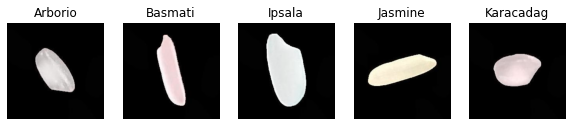

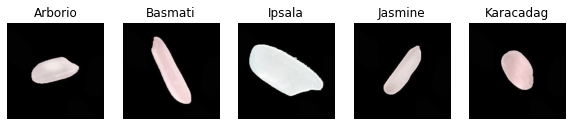

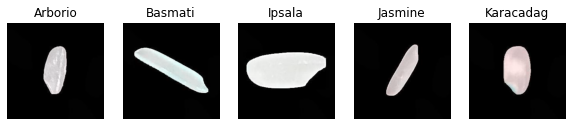

In [9]:
for i in range(3):
    load_random_img(rootPath, class_names)

In [10]:
# !pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
import splitfolders
#(Train-Val-Test)
splitfolders.ratio(rootPath, output='Datasets', seed=123, ratio=(.7,.15,.15), group_prefix=None)

Copying files: 75000 files [00:23, 3147.71 files/s]


In [12]:
batch_size = 128
img_height, img_width = 256, 256
input_shape = (img_height, img_width, 3)

In [14]:
# Data Pre-processing
# ImageDataGenerator can read images from disk and preprocess them into proper tensors.
# It will also set up generators that convert these images into batches of tensors—helpful when training the network.
datagen = ImageDataGenerator(rescale=1./255)

In [15]:
Train = datagen.flow_from_directory(
    'Datasets/train',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    subset = "training",
    class_mode='categorical')

Val = datagen.flow_from_directory(
    'Datasets/val',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=False)

Test = datagen.flow_from_directory(
    'Datasets/test',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=False)

Found 52500 images belonging to 5 classes.
Found 11250 images belonging to 5 classes.
Found 11250 images belonging to 5 classes.


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 516128)            0         
                                                                 
 dense_4 (Dense)             (None, 512)               264258048 
                                                                 
 dense_5 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 264,261,509
Trainable params: 264,261,509
Non-trainable params: 0
________________________________________

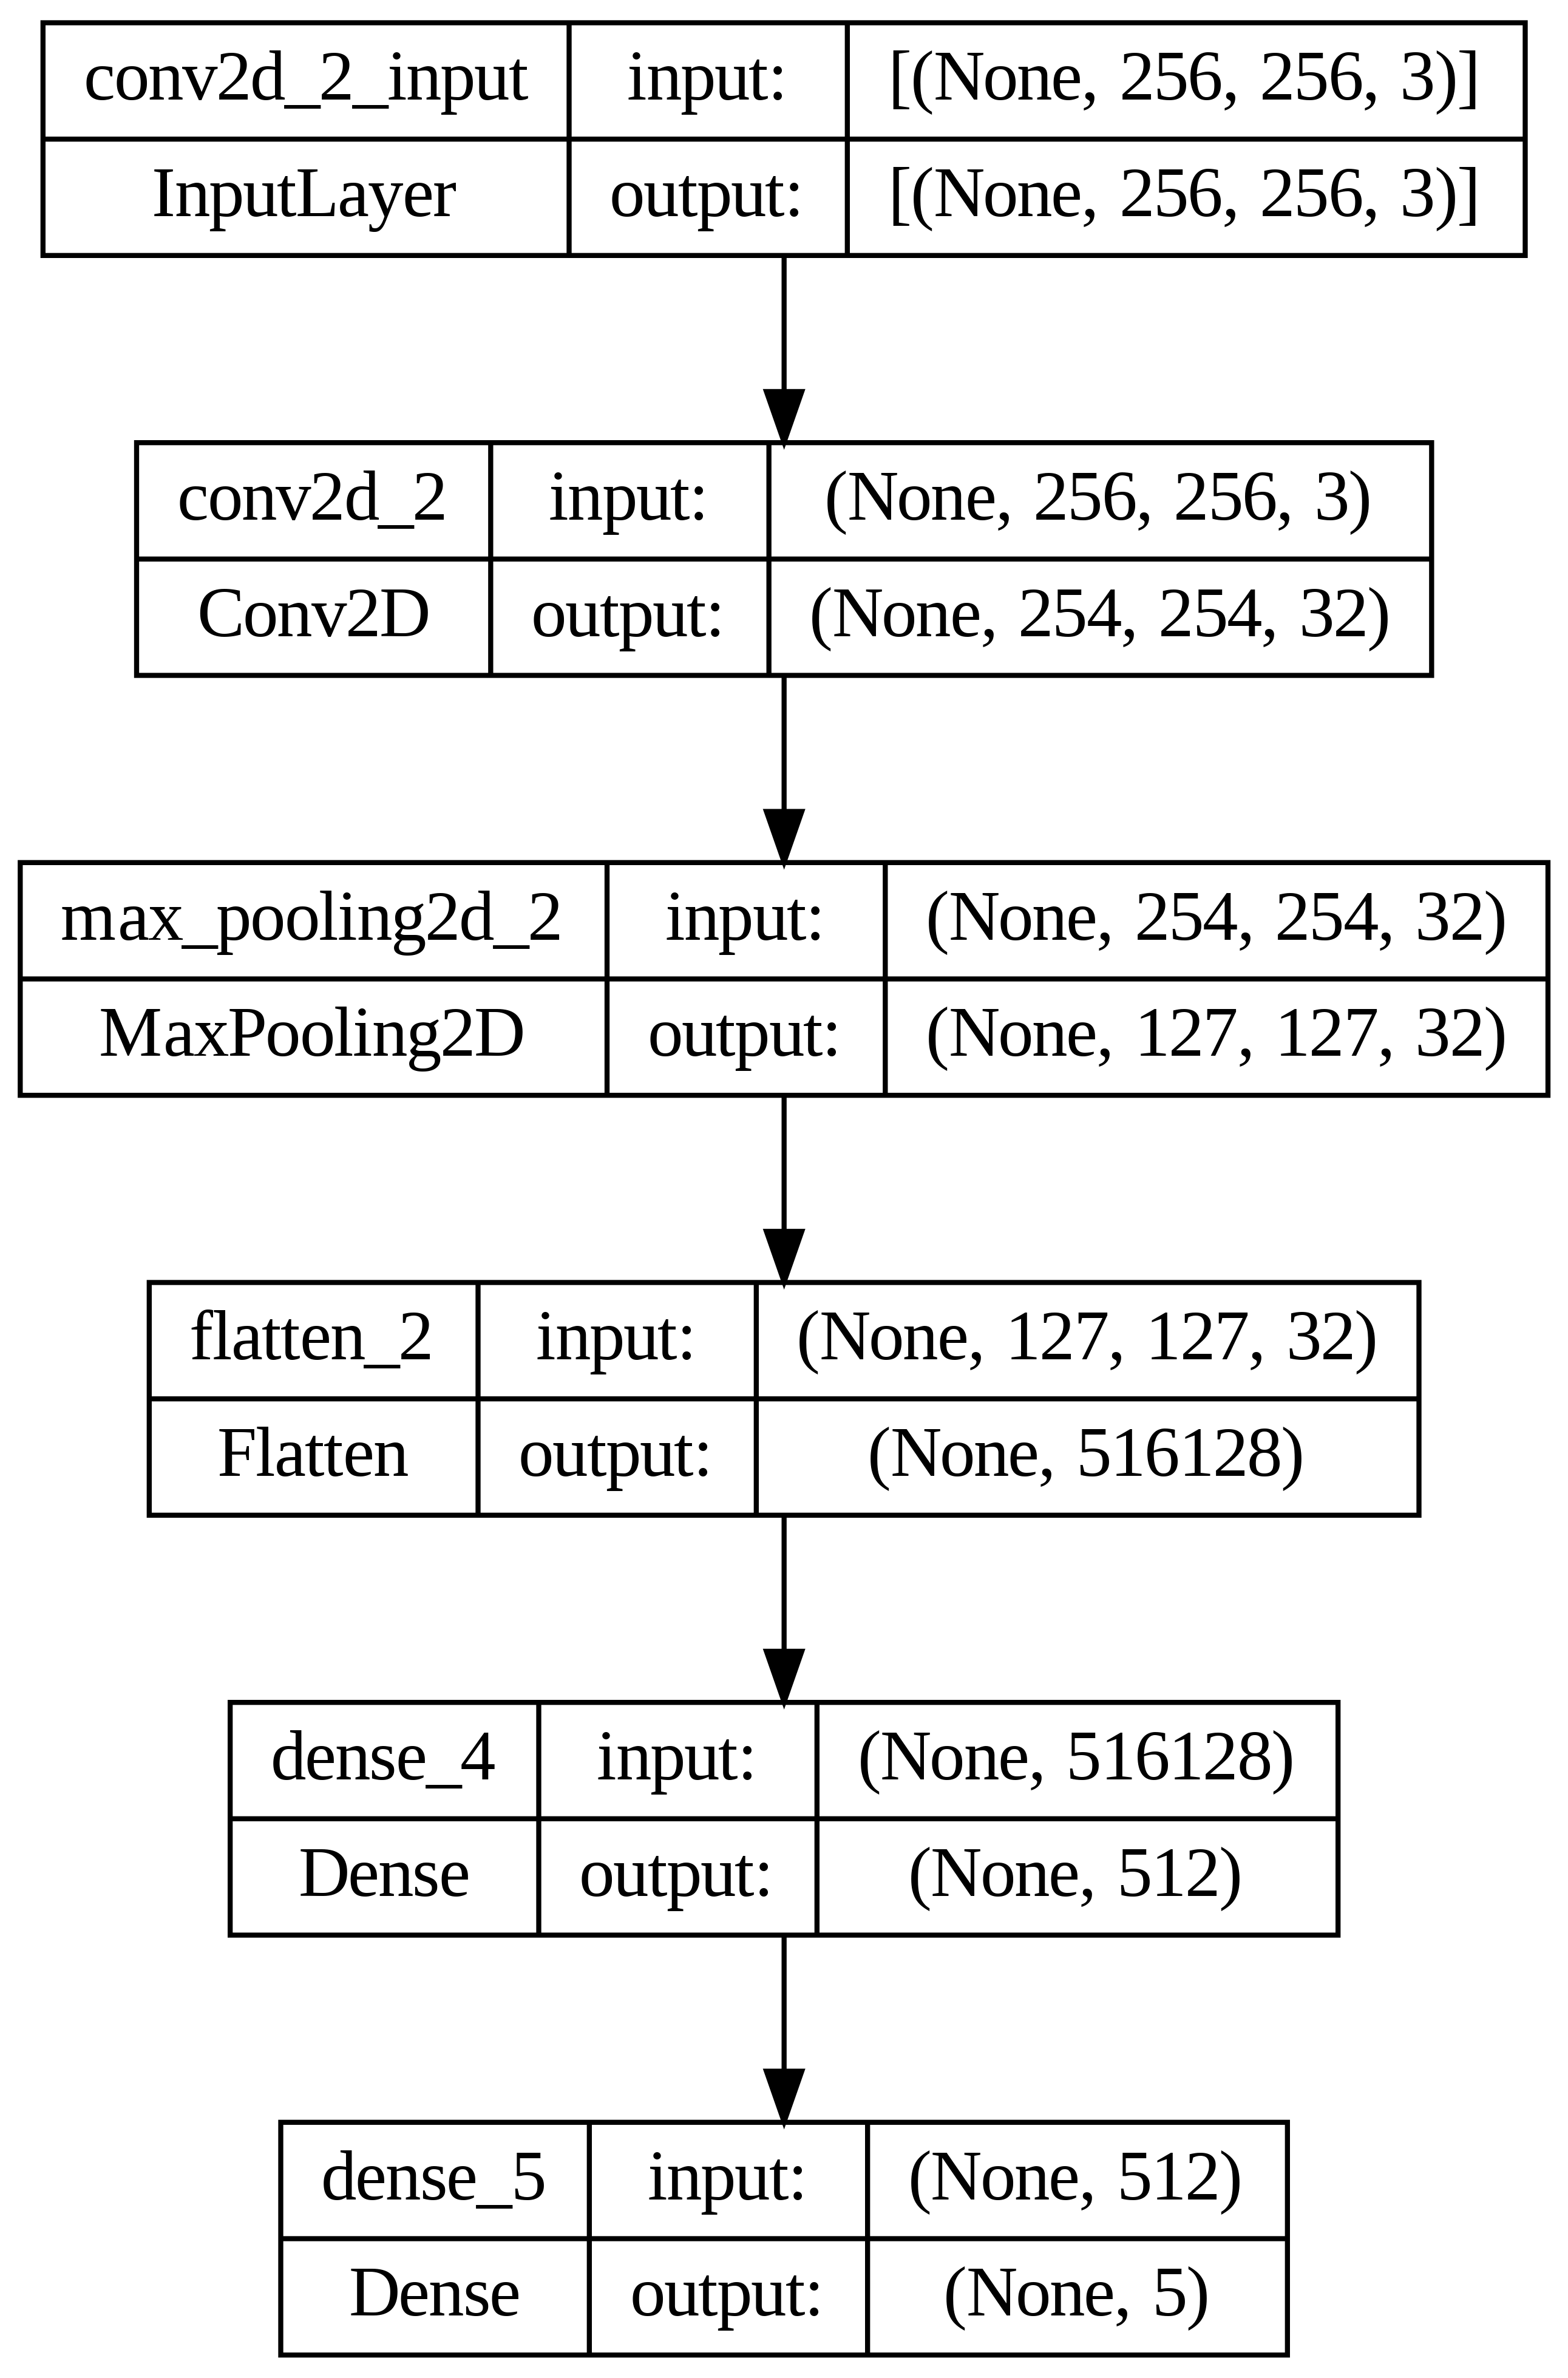

In [19]:
model = Sequential()

# Convolution
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(256,256,3)))

#Pooling
model.add(MaxPool2D(pool_size=(2,2), strides =2))

#Flattening
model.add(Flatten())

#Full Conection
model.add(Dense(512, activation='relu'))

#Output layer
model.add(Dense(units=5, activation='softmax'))
model.summary()
plot_model(model, to_file='my_model.png', show_shapes=True, dpi=600)

In [20]:
epochs=100
batch_size=128
train_data_length=len(Train.labels)
validation_data_length=len(Val.labels)
steps_per_epoch=(train_data_length//batch_size)
validation_steps=(validation_data_length//batch_size)
checkpoint = ModelCheckpoint("my_model.h5",monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
    #early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=1, mode='auto')   #  # In early_stopping (patience=7) for pre_trained model   
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=7, verbose=1, mode='auto')  # In early_stopping (patience=7) for customize model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history=model.fit(Train, steps_per_epoch=steps_per_epoch,validation_data=Val, validation_steps=validation_steps, epochs=epochs, callbacks=[checkpoint,early_stopping], verbose=1)
print('model training completed')

Epoch 1/100
410/410 [==============================] - ETA: 0s - loss: 0.2848 - accuracy: 0.9606
Epoch 1: val_accuracy improved from -inf to 0.98743, saving model to my_model.h5
410/410 [==============================] - 163s 375ms/step - loss: 0.2848 - accuracy: 0.9606 - val_loss: 0.0372 - val_accuracy: 0.9874
Epoch 2/100
410/410 [==============================] - ETA: 0s - loss: 0.0247 - accuracy: 0.9913
Epoch 2: val_accuracy improved from 0.98743 to 0.98869, saving model to my_model.h5
410/410 [==============================] - 172s 418ms/step - loss: 0.0247 - accuracy: 0.9913 - val_loss: 0.0360 - val_accuracy: 0.9887
Epoch 3/100
410/410 [==============================] - ETA: 0s - loss: 0.0144 - accuracy: 0.9953
Epoch 3: val_accuracy improved from 0.98869 to 0.99012, saving model to my_model.h5
410/410 [==============================] - 170s 413ms/step - loss: 0.0144 - accuracy: 0.9953 - val_loss: 0.0325 - val_accuracy: 0.9901
Epoch 4/100
410/410 [==============================] - 

In [21]:
score = model.evaluate(Test, verbose=1)
print(f'Model Loss: {score[0]}, Accuracy: {score[1]*100}')

88/88 [==============================] - 25s 284ms/step - loss: 0.1092 - accuracy: 0.9741
Model Loss: 0.10922042280435562, Accuracy: 97.4133312702179


In [22]:
from sklearn.metrics import classification_report, confusion_matrix

88/88 [==============================] - 21s 241ms/step


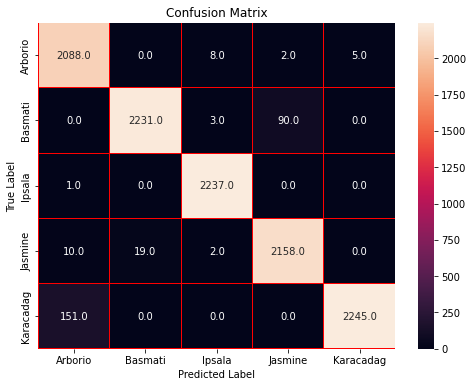

In [24]:
Y_pred = model.predict(Test)
y_pred = np.argmax(Y_pred, axis=1) #Max prob between 5 values
confusion_mtx = confusion_matrix(y_pred, Test.classes)
f,ax = plt.subplots(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,
            linecolor="red", 
            fmt= '.1f',ax=ax, cmap='rocket')

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(Test.class_indices)
ax.yaxis.set_ticklabels(class_names)
plt.title("Confusion Matrix")
plt.show()


In [25]:
print(classification_report(Test.classes, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.93      0.96      2250
           1       0.96      0.99      0.98      2250
           2       1.00      0.99      1.00      2250
           3       0.99      0.96      0.97      2250
           4       0.94      1.00      0.97      2250

    accuracy                           0.97     11250
   macro avg       0.98      0.97      0.97     11250
weighted avg       0.98      0.97      0.97     11250



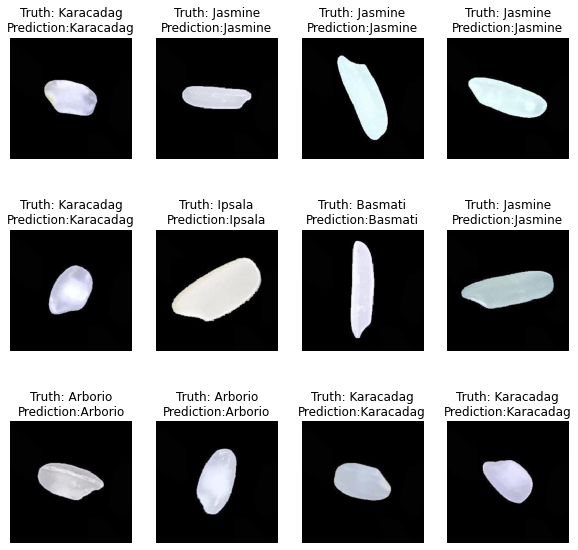

In [26]:
plt.figure(figsize=(10, 10))
#The next function returns a batch from the dataset. The return value is in form of (training features and labels)
x, label= Train.next()  
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(x[i])
    result = np.where(label[i]==1)
    predict = model(tf.expand_dims(x[i], 0))
    score = tf.nn.softmax(predict[0])
    score_label = class_names[np.argmax(score)]
    plt.title(f'Truth: {class_names[result[0][0]]}\nPrediction:{score_label}')
    plt.axis(False)